In [27]:
# Setting up the workspace by importing all of the necessary libraries.

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, r2_score, confusion_matrix,f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier
from sklearn import svm


In [21]:
def cm(y_real, y_pred, t='test'):
    cf = confusion_matrix(y_real, y_pred)
    print(f"Confusion Matrix {t}: ")
    akws = {"ha": 'center',"va": 'top'}
    sns.heatmap(cf/(np.sum(cf)),annot=True, fmt='0.2%',cmap='Blues', annot_kws=akws, cbar=False)

    akws = {"ha": 'center',"va": 'bottom'}
    sns.heatmap(cf,annot=True, fmt='0',cmap='Blues', annot_kws=akws)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [11]:
df = pd.read_csv('Cleaned_joind_data.csv')
df.head()

,id,WTDRD1,WTDR2D,DR1DRSTZ,DRABF,DRDINT,DR1DAY,DBQ095Z,DBD100,DRQSPREP,...,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V,DIQ010,DIQ160
0,73557,16888.327864,12930.890649,1,2.0,2.0,2.0,3.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,73558,17932.143865,12684.148869,1,2.0,2.0,1.0,1.0,2.0,3.0,...,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,0.0
2,73559,59641.812930,39394.236709,1,2.0,2.0,6.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,73560,142203.069917,125966.366442,1,2.0,2.0,3.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,73561,59052.357033,39004.892993,1,2.0,2.0,1.0,4.0,0.0,4.0,...,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0


In [12]:
X = df.drop(['DIQ010'], axis=1)
y = df['DIQ010']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=81)

In [14]:
y_test.value_counts()


2.0    1663
1.0     193
Name: DIQ010, dtype: int64

In [15]:
rf = RandomForestClassifier()

In [17]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
train_pred = rf.predict(X_train)
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

Confusion Matrix test: 


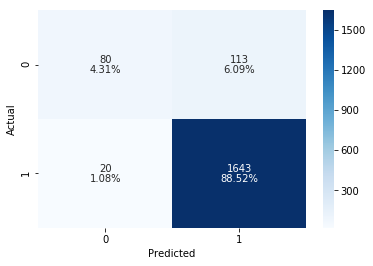

In [22]:
cm(y_train, test_pred)

In [26]:

print('Accuracy: ', precision_score(y_test, test_pred))

Accuracy:  0.8


In [28]:
select_feature = SelectKBest(chi2, k=5).fit(X_train, y_train)

In [30]:
select_feature_df = pd.DataFrame({'Feature':list(X_train.columns),
                                 'Scores': select_feature.scores_})
select_feature_df.sort_values(by='Scores', ascending=False )

,Feature,Scores
45,DR1TLZ,89257.394720
1,WTDRD1,82431.836954
42,DR1TBCAR,66495.771587
72,DR1TMOIS,63482.932213
95,DR1BWATZ,62662.305297
93,DR1.320Z,36043.757747
44,DR1TLYCO,21631.664503
69,DR1TCAFF,16743.618802
19,DRQSDT7,7554.991432
67,DR1TPOTA,6557.370873


In [31]:
X_train_chi = select_feature.transform(X_train)
X_test_chi = select_feature.transform(X_test)

In [32]:
rf.fit(X_train_chi, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [35]:
train_pred_chi = rf.predict(X_train_chi)
test_pred_chi = rf.predict(X_test_chi)

In [37]:
cm(train_pred_chi, test_pred_chi)

ValueError: Found input variables with inconsistent numbers of samples: [7424, 1856]